In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
from tqdm import tqdm
import argparse
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
import os
import sys
import logging
import logging.handlers
from PIL import Image

# Parser

In [2]:
parser = argparse.ArgumentParser(description='Domain adaptation')
parser.add_argument("--batch_size", type=int, default="400", help="batch size")
parser.add_argument("--learning_rate", type=float, default=1e-3, help="learning rate")
parser.add_argument("--momentum", type=float, default=0.5, help="momentum")
parser.add_argument("--gpu_num", type=int, default=0, help="gpu num")
parser.add_argument("--seed", type=int, default=123, help="munually set seed")
parser.add_argument("--save_path", type=str, default="../train_related", help="save path")
parser.add_argument("--subfolder", type=str, default='domain_origin_dann_svhn_to_mnist', help="subfolder name")
parser.add_argument("--wtarget", type=float, default=0.7, help="target weight")
parser.add_argument("--model_save_period", type=int, default=2, help="save period")
parser.add_argument("--epochs", type=int, default=2000, help="label shuffling")
parser.add_argument("--dann_weight", type=float, default=1, help="weight for label shuffling")
parser.add_argument("--start_origin_dann", type=int, default=100, help="when to start shuffling")
parser.add_argument("--use_gpu", type=int, default=0, help="whether using gpu to train")


args = parser.parse_args()
# snap shot of py file and command
python_file_name = sys.argv[0]


usage: ipykernel_launcher.py [-h] [--batch_size BATCH_SIZE] [--learning_rate LEARNING_RATE] [--momentum MOMENTUM] [--gpu_num GPU_NUM]
                             [--seed SEED] [--save_path SAVE_PATH] [--subfolder SUBFOLDER] [--wtarget WTARGET]
                             [--model_save_period MODEL_SAVE_PERIOD] [--epochs EPOCHS] [--dann_weight DANN_WEIGHT]
                             [--start_origin_dann START_ORIGIN_DANN]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/tianqinl/.local/share/jupyter/runtime/kernel-cceb65dc-79f9-462c-9442-12406ea899aa.json


SystemExit: 2

/home/tianqinl/anaconda3/envs/pgm/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# local only

In [4]:
# # local only
# class local_args:
#     def __init__(self, **entries):
#         self.__dict__.update(entries)
        
# args = local_args(**{
#     'batch_size': 400,
#     'learning_rate': 1e-3,
#     'momentum': 0.5,
#     'gpu_num': 0,
#     'seed': 123,
#     'save_path': "../train_related",
#     'epochs': 2,
#     'subfolder': "testing",
#     'wtarget': 0.7,
#     'dann_weight': 1,
#     'model_save_period': 2,
#     'start_origin_dann': 0,
#     'use_gpu': 0,
# })

In [6]:
if args.use_gpu == 1 and torch.cuda.is_available():
    device = torch.device('cuda:{}'.format(args.gpu_num))
else:
    device = 'cpu'
print(device)
# seed
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
cudnn.deterministic = True
torch.backends.cudnn.deterministic = True






model_sub_folder = args.subfolder + '/origin_dann_weight_%f_learningrate_%f'%(args.dann_weight, args.learning_rate)
save_folder = os.path.join(args.save_path, model_sub_folder)
if not os.path.exists(save_folder):
    os.makedirs(save_folder)   


cpu


In [7]:

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logfile_path = os.path.join(save_folder, 'logfile.log')
if os.path.isfile(logfile_path):
    os.remove(logfile_path)
    
file_log_handler = logging.FileHandler(logfile_path)
logger.addHandler(file_log_handler)

stdout_log_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(stdout_log_handler)

attrs = vars(args)
for item in attrs.items():
    logger.info("%s: %s"%item)
logger.info("Training Save Path: {}".format(save_folder))


batch_size: 400
learning_rate: 0.001
momentum: 0.5
gpu_num: 0
seed: 123
save_path: ../train_related
epochs: 2
subfolder: testing
wtarget: 0.7
dann_weight: 1
model_save_period: 2
start_origin_dann: 0
use_gpu: 0
Training Save Path: ../train_related/testing/origin_dann_weight_1.000000_learningrate_0.001000


# Data loader

In [8]:
mnist_trainset = datasets.MNIST(root='../data', train=True, download=True, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

In [9]:
mnist_testset = datasets.MNIST(root='../data', train=False, download=True, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

In [10]:
svhn_trainset = datasets.SVHN(root='../data', split='train', download=True, transform=torchvision.transforms.Compose([
                    torchvision.transforms.Resize((28, 28)),
                    torchvision.transforms.Grayscale(num_output_channels=1),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize([0.5], [0.5])]))

Using downloaded and verified file: ../data/train_32x32.mat


In [11]:
svhn_testset = datasets.SVHN(root='../data', split='test', download=True, transform=torchvision.transforms.Compose([
                    torchvision.transforms.Resize((28, 28)),
                    torchvision.transforms.Grayscale(num_output_channels=1),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize([0.5], [0.5])]))

Using downloaded and verified file: ../data/test_32x32.mat


In [12]:
# # mnist
# train_mnist_loader = DataLoader(mnist_trainset, batch_size=args.batch_size, shuffle=True)
# test_mnist_loader = DataLoader(mnist_testset, batch_size=args.batch_size, shuffle=True)
# examples = enumerate(test_mnist_loader)
# batch_idx, (example_data, example_targets) = next(examples)


# fig = plt.figure()
# for i in range(6):
#   plt.subplot(2,3,i+1)
#   plt.tight_layout()
#   plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
#   plt.title("Ground Truth: {}".format(example_targets[i]))
#   plt.xticks([])
#   plt.yticks([])

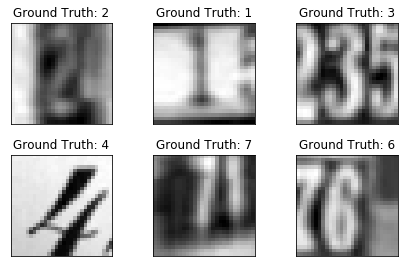

In [13]:
# svhn
train_svhn_loader = DataLoader(svhn_trainset, batch_size=args.batch_size, shuffle=True)
test_svhn_loader = DataLoader(svhn_trainset, batch_size=args.batch_size, shuffle=True)
examples = enumerate(train_svhn_loader)
batch_idx, (example_data, example_targets) = next(examples)


fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

In [15]:
# reload data
train_mnist_loader = DataLoader(mnist_trainset, batch_size=args.batch_size, shuffle=True)
test_mnist_loader = DataLoader(mnist_testset, batch_size=args.batch_size, shuffle=True)
train_svhn_loader = DataLoader(svhn_trainset, batch_size=args.batch_size, shuffle=True)
test_svhn_loader = DataLoader(svhn_trainset, batch_size=args.batch_size, shuffle=True)

## Process data for cancat with source and target label

In [16]:
class ConcatDataset(Dataset):
    def __init__(self, x, y, mode='mnist'):
        self.x = x
        self.y = y
        self.len = self.x.shape[0]
        self.mode = mode
        if self.mode == 'mnist':
            self.transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])
        elif self.mode == 'svhn':
            self.transform = torchvision.transforms.Compose([
                    torchvision.transforms.Resize((28, 28)),
                    torchvision.transforms.Grayscale(num_output_channels=1),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize([0.5], [0.5])])

    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        if self.mode == 'mnist':
            img = Image.fromarray(self.x[index].numpy(), mode='L')
            img = self.transform(img)
        elif self.mode == 'svhn':
            img = Image.fromarray(np.transpose(self.x[index], (1, 2, 0)))
            img = self.transform(img)
    
        return img, self.y[index]

In [17]:

concat_mnist_train = ConcatDataset(mnist_trainset.data, torch.zeros(mnist_trainset.data.shape[0], dtype=torch.long), mode = 'mnist')
concat_svhn_train = ConcatDataset(svhn_trainset.data, torch.ones(svhn_trainset.data.shape[0], dtype=torch.long), mode = 'svhn')


adverial_dataset = torch.utils.data.ConcatDataset([concat_mnist_train, concat_svhn_train])
# [i[1] for i in [adverial_dataset[m] for m in torch.randint(0, len(adverial_dataset), (100,))]]
adverial_loader = DataLoader(adverial_dataset, batch_size=args.batch_size, shuffle=True)

# Model

In [18]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 30)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [29]:
class FNN(nn.Module):
    def __init__(self, d_in, d_h1, d_h2, d_out, dp=0.2):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(d_in, d_h1)
        self.ln1 = nn.LayerNorm(d_h1)
        self.relu1 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(dp)
        self.fc2 = nn.Linear(d_h1, d_h2)
        self.ln2 = nn.LayerNorm(d_h2)
        self.relu2 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout(dp)
        self.fc3 = nn.Linear(d_h2, d_out)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ln1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.ln2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x
    
    def before_lastlinear(self, x):
        x = self.fc1(x)
        x = self.ln1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.ln2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        return x

        

In [30]:
class Adversial_loss(nn.Module):
    def __init__(self):
        super(Adversial_loss, self).__init__()
    
    def forward(self):
        pass

In [31]:
def weights_init(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
    elif type(m) == nn.LayerNorm:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)


In [32]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)

encoder = Encoder().to(device)
CNet = FNN(d_in=30, d_h1=100, d_h2=100, d_out=10, dp=0.2).to(device)
DomainCNet = FNN(d_in=30, d_h1=100, d_h2=100, d_out=2, dp=0.2).to(device)




optimizerEncoder = optim.Adam(encoder.parameters(), lr=args.learning_rate)
optimizerCNet = optim.Adam(CNet.parameters(), lr=args.learning_rate)
optimizerDomainCNet = optim.Adam(DomainCNet.parameters(), lr=args.learning_rate)

criterion_classifier = nn.CrossEntropyLoss().to(device)
# criterion_adverisal = 

encoder.apply(weights_init)
CNet.apply(weights_init)
DomainCNet.apply(weights_init)

cuda:0


FNN(
  (fc1): Linear(in_features=30, out_features=100, bias=True)
  (ln1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (relu1): ReLU(inplace=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (ln2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (relu2): ReLU(inplace=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=100, out_features=2, bias=True)
)

# Train

In [1]:
target_acc_label_ = []
source_acc_ = []
source_test_acc_ = []
target_test_acc_ = []

logger.info('Started Training')


for epoch in range(args.epochs):
    # update classifier
    # on target domain mnist
    CNet.train()
    encoder.train()
    source_acc = 0.0
    num_datas = 0.0
    for batch_id, (source_x, source_y) in tqdm(enumerate(train_svhn_loader), total=len(train_svhn_loader)):
        optimizerCNet.zero_grad()
        optimizerEncoder.zero_grad()
        source_x = source_x.to(device).float()
        source_y = source_y.to(device)
        num_datas += source_x.size(0)
        source_x_embedding = encoder(source_x)
        pred = CNet(source_x_embedding)
        source_acc += (pred.argmax(-1) == source_y).sum().item()
        loss = criterion_classifier(pred, source_y)
        loss.backward()
        optimizerCNet.step()
        optimizerEncoder.step()
        
        
    source_acc = source_acc / num_datas
    source_acc_.append(source_acc)
    
    
    
    # on target domain svhn
#     target_acc = 0.0
#     num_datas = 0.0
#     CNet.train()
#     encoder.train()

#     for batch_id, (target_x, target_y) in tqdm(enumerate(train_svhn_loader), total=len(train_svhn_loader)):
#         optimizerCNet.zero_grad()
#         optimizerEncoder.zero_grad()
#         target_x = target_x.to(device).float()
#         target_y = target_y.to(device)
#         num_datas += target_x.size(0)
#         target_x_embedding = encoder(target_x)
#         pred = CNet(target_x_embedding)
#         target_acc += (pred.argmax(-1) == target_y).sum().item()
#         loss = criterion_classifier(pred, target_y)
#         loss.backward()
#         optimizerCNet.step()
#         optimizerEncoder.step()
        
    
#     target_acc = target_acc / num_datas
#     target_acc_label_.append(target_acc)
    
    
    # DANN shuffle
    if epoch >= args.start_origin_dann:
        DomainCNet.train()
        encoder.train()
        num_datas = 0.0
        for batch_id, (adv_x, adv_y) in tqdm(enumerate(adverial_loader), total=len(adverial_loader)):
            # encoder loss
            optimizerCNet.zero_grad()
            optimizerEncoder.zero_grad()
            adv_x = adv_x.to(device).float()
            adv_y = adv_y.to(device)
            num_datas += adv_x.size(0)
            adv_x_embedding = encoder(adv_x)
            pred = DomainCNet(adv_x_embedding)
            # adv_acc += (pred.argmax(-1) == adv_y).sum().item()
            loss = - args.dann_weight * criterion_classifier(pred, adv_y)
            loss.backward()
            optimizerEncoder.step()

        for batch_id, (adv_x, adv_y) in tqdm(enumerate(adverial_loader), total=len(adverial_loader)):
            # domain layer loss
            DomainCNet.train()
            encoder.train()
            optimizerCNet.zero_grad()
            optimizerEncoder.zero_grad()
            adv_x = adv_x.to(device).float()
            adv_y = adv_y.to(device)
            adv_x_embedding = encoder(adv_x)
            pred = DomainCNet(adv_x_embedding)
            # adv_acc += (pred.argmax(-1) == adv_y).sum().item()
            loss_adv = args.dann_weight * criterion_classifier(pred, adv_y)
            loss_adv.backward()
            optimizerDomainCNet.step()    

    
    
    # eval on source   
    source_test_acc = 0.0
    num_datas = 0.0
    CNet.eval()
    encoder.eval()
    
    for batch_id, (source_x, source_y) in tqdm(enumerate(test_svhn_loader), total=len(test_svhn_loader)):
        optimizerCNet.zero_grad()
        optimizerEncoder.zero_grad()
        source_x = source_x.to(device).float()
        source_y = source_y.to(device)
        num_datas += source_x.size(0)
        source_x_embedding = encoder(source_x)
        pred = CNet(source_x_embedding)
        source_test_acc += (pred.argmax(-1) == source_y).sum().item()
        
    source_test_acc = source_test_acc / num_datas
    source_test_acc_.append(source_test_acc)
    
    # eval on target 
    num_datas = 0.0
    target_test_acc = 0.0
    for batch_id, (target_x, target_y) in tqdm(enumerate(test_mnist_loader), total=len(test_mnist_loader)):
        optimizerCNet.zero_grad()
        optimizerEncoder.zero_grad()
        target_x = target_x.to(device).float()
        target_y = target_y.to(device)
        num_datas += target_x.size(0)
        target_x_embedding = encoder(target_x)
        pred = CNet(target_x_embedding)
        target_test_acc += (pred.argmax(-1) == target_y).sum().item()
    
    target_test_acc = target_test_acc / num_datas
    target_test_acc_.append(target_test_acc)
    
    if epoch % args.model_save_period == 0:
        torch.save(DomainCNet.state_dict(), os.path.join(save_folder, 'DomainCNet_%i.t7'%(epoch+1)))
        torch.save(encoder.state_dict(), os.path.join(save_folder, 'encoder_%i.t7'%(epoch+1)))
        torch.save(CNet.state_dict(), os.path.join(save_folder, 'CNet_%i.t7'%(epoch+1)))

    
    logger.info('Epochs %i: source train acc: %f; source test acc: %f; target test acc: %f'%(epoch+1, source_acc, source_test_acc, target_test_acc))
    np.save(os.path.join(args.save_path, model_sub_folder, 'source_acc_.npy'),source_acc_)
    np.save(os.path.join(args.save_path, model_sub_folder, 'source_test_acc_.npy'),source_test_acc_)
    np.save(os.path.join(args.save_path, model_sub_folder, 'target_test_acc_.npy'),target_test_acc_)

NameError: name 'logger' is not defined